In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchio as tio
import os
import nibabel as nib
from torch import nn
from scipy.ndimage import zoom

/home/alpaco/anaconda3/envs/msk/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 재현성을 위한 시드 설정
import random
import numpy as np
import torch

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 코드 시작 부분에 추가
seed_everything(42)  # 원하는 시드 값 설정

In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        x = self.double_conv(x)
        return x
    
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(kernel_size=2, stride=2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        x = self.encoder(x)
        return x
    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()
        self.up = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Make sure size data when you combine are the same size
        diffX = x2.size()[4] - x1.size()[4]
        diffY = x2.size()[3] - x1.size()[3]
        diffZ = x2.size()[2] - x1.size()[2]
        
        x1 = torch.nn.functional.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2))
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    

class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.out_conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.out_conv(x)
    
class UNET3D(nn.Module):
    def __init__(self, in_channels, out_channels, n_classes):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_classes = n_classes
        
        self.double_conv = DoubleConv(self.in_channels, self.out_channels)
        # encoder downsamplers
        self.down_1 = Down(self.out_channels, self.out_channels*2)
        self.down_2 = Down(self.out_channels*2, self.out_channels*4)
        self.down_3 = Down(self.out_channels*4, self.out_channels*8)
        self.down_4 = Down(self.out_channels*8, self.out_channels*16)

        # decoder upsamplers
        self.up_4 = Up(self.out_channels*16, self.out_channels*8)
        self.up_3 = Up(self.out_channels*8, self.out_channels*4)
        self.up_2 = Up(self.out_channels*4, self.out_channels*2)
        self.up_1 = Up(self.out_channels*2, self.out_channels)

        # output
        self.out = Out(self.out_channels, self.n_classes)
        
        self.dropout = nn.Dropout3d(0.5)
    def forward(self, x):
        # Encoder
        en_1 = self.double_conv(x)
#         en_1 = self.dropout(en_1)
        en_2 = self.down_1(en_1)
        en_2 = self.dropout(en_2)
        en_3 = self.down_2(en_2)
#         en_3 = self.dropout(en_3)
        en_4 = self.down_3(en_3)
        en_4 = self.dropout(en_4)
        en_5 = self.down_4(en_4)
#         en_5 = self.dropout(en_5)
        
        # Decoder
        de_4 = self.up_4(en_5, en_4)
        de_4 = self.dropout(de_4)
        de_3 = self.up_3(de_4, en_3)
#         de_3 = self.dropout(de_3)
        de_2 = self.up_2(de_3, en_2)
        de_2 = self.dropout(de_2)
        de_1 = self.up_1(de_2, en_1)
#         de_1 = self.dropout(de_1)
        
        out = self.out(de_1)
        return out

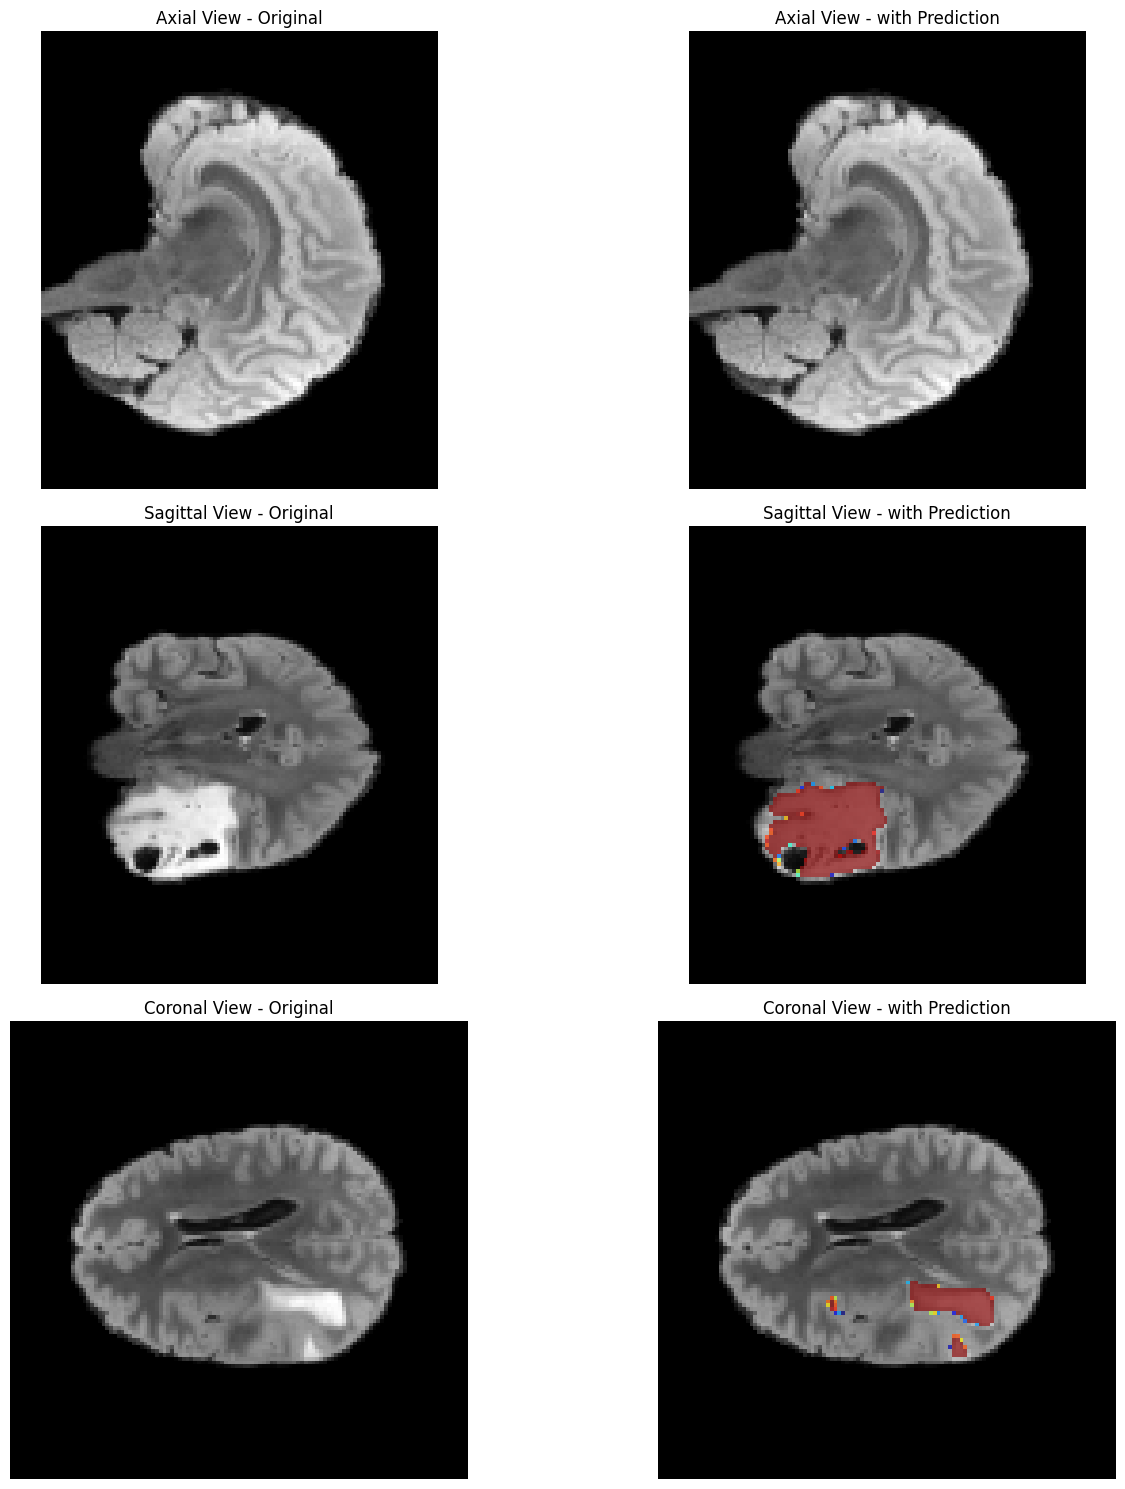

Prediction saved as: tumor_prediction_flair_dice_control.nii

Shape information:
Original image shape: (240, 240, 155)
Prediction shape (before resize): (120, 120, 104)
Prediction shape (after resize): (240, 240, 155)


In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchio as tio
import os
import nibabel as nib
from torch import nn
from scipy.ndimage import zoom

# [이전의 모델 클래스 정의 부분은 동일하게 유지]

# 모델 로드
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = UNET3D(in_channels=1, out_channels=32, n_classes=1)
model.load_state_dict(torch.load('/home/alpaco/msk/Unet3D_2021_flair/Unet3D_flair_control.pt'))
model.to(device)
model.eval()

# 이미지 로드 및 전처리
image_path = '/home/alpaco/msk/BraTS2021_Data/BraTS2021_00033/BraTS2021_00033_flair.nii.gz'
ref_img = nib.load(image_path)  # 원본 이미지 로드
original_shape = ref_img.get_fdata().shape  # 원본 shape 저장

resample = tio.Resample((2,2,1.5))
img = tio.ScalarImage(image_path)
img = resample(img)
img_array = np.array(img)
img_array = np.squeeze(img_array, axis=0)

# 정규화
img_normalized = (img_array - np.min(img_array))/(np.max(img_array) - np.min(img_array))

# 모델 입력을 위한 텐서 변환
img_tensor = torch.Tensor(img_normalized)
img_tensor = torch.unsqueeze(img_tensor, dim=0)
img_tensor = torch.unsqueeze(img_tensor, dim=0)
img_tensor = img_tensor.to(device)

# 예측 및 후처리
with torch.no_grad():
    prediction = model(img_tensor)
    prediction = torch.sigmoid(prediction)
    prediction = prediction.squeeze().cpu().numpy()

# 뇌 영역 마스크 생성 
brain_mask = (img_normalized > 0.1).astype(float)

# 임계값 적용 및 뇌 영역 외 예측 제거
thresholded_prediction = np.where(prediction < 0.1, 0, prediction)
thresholded_prediction = thresholded_prediction * brain_mask

# 원본 크기로 리사이즈
scale_factors = np.array(original_shape) / np.array(thresholded_prediction.shape)
resized_prediction = zoom(thresholded_prediction, scale_factors)

# nii 파일로 저장
prediction_nii = nib.Nifti1Image(resized_prediction, ref_img.affine, ref_img.header)
output_path = 'tumor_prediction_flair_dice_control.nii'
nib.save(prediction_nii, output_path)

# 시각화 (확인용)
middle_slices = [img_normalized.shape[i]//2 for i in range(3)]

plt.figure(figsize=(15, 15))
views = ['Axial', 'Sagittal', 'Coronal']
slices = [
    (middle_slices[0], slice(None), slice(None)),
    (slice(None), middle_slices[1], slice(None)),
    (slice(None), slice(None), middle_slices[2])
]

for idx, (view, sl) in enumerate(zip(views, slices)):
    # Original
    plt.subplot(3, 2, 2*idx + 1)
    plt.imshow(img_normalized[sl], cmap='gray')
    plt.title(f'{view} View - Original')
    plt.axis('off')
    
    # With prediction
    plt.subplot(3, 2, 2*idx + 2)
    plt.imshow(img_normalized[sl], cmap='gray')
    masked_pred = np.ma.masked_where(thresholded_prediction[sl] < 0.15, thresholded_prediction[sl])
    plt.imshow(masked_pred, cmap='jet', alpha=0.7)
    plt.title(f'{view} View - with Prediction')
    plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Prediction saved as: {output_path}")
print("\nShape information:")
print("Original image shape:", original_shape)
print("Prediction shape (before resize):", prediction.shape)
print("Prediction shape (after resize):", resized_prediction.shape)

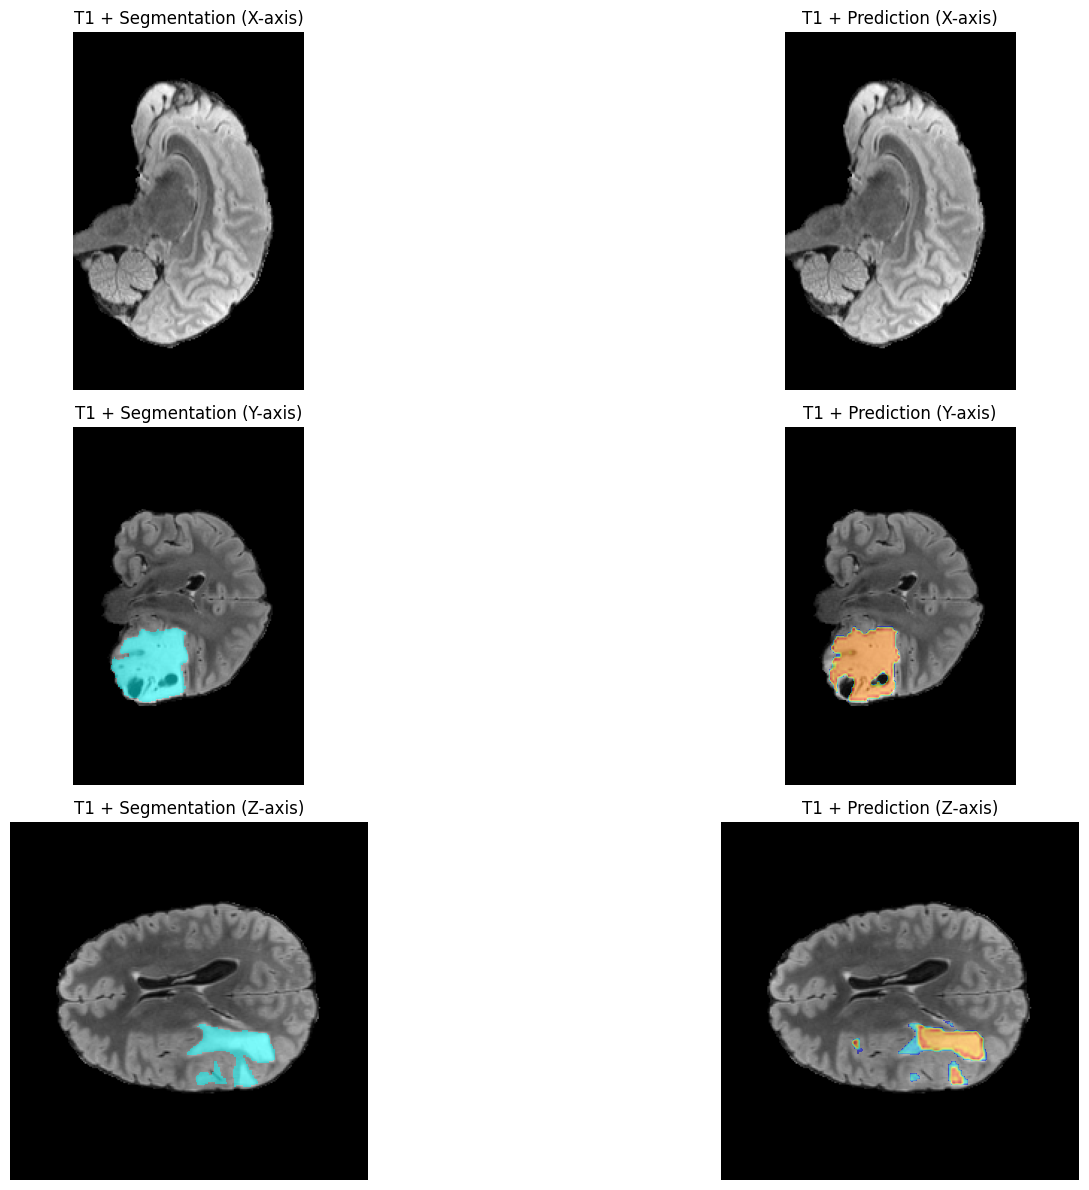

In [6]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# 파일 경로
t1_path = '/home/alpaco/msk/BraTS2021_Data/BraTS2021_00033/BraTS2021_00033_flair.nii.gz'
seg_file_path = '/home/alpaco/msk/BraTS2021_Data/BraTS2021_00033/BraTS2021_00033_seg.nii.gz'
pred_file_path = '/home/alpaco/msk/Unet3D_2021_flair/tumor_prediction_flair_dice_control.nii'

# 데이터 로드
t1_img = nib.load(t1_path).get_fdata()
seg_img = nib.load(seg_file_path).get_fdata()
pred_img = nib.load(pred_file_path).get_fdata()

# 정규화
t1_normalized = (t1_img - t1_img.min()) / (t1_img.max() - t1_img.min())

# 중심 슬라이스 계산
x_slice = t1_normalized.shape[0] // 2
y_slice = t1_normalized.shape[1] // 2
z_slice = t1_normalized.shape[2] // 2

# 슬라이스 리스트
slices = [
    (t1_normalized[x_slice, :, :], seg_img[x_slice, :, :], pred_img[x_slice, :, :], "X-axis"),
    (t1_normalized[:, y_slice, :], seg_img[:, y_slice, :], pred_img[:, y_slice, :], "Y-axis"),
    (t1_normalized[:, :, z_slice], seg_img[:, :, z_slice], pred_img[:, :, z_slice], "Z-axis"),
]

# 시각화
plt.figure(figsize=(18, 12))
for idx, (t1_slice, seg_slice, pred_slice, axis) in enumerate(slices):
    # T1과 Segmentation Overlay
    plt.subplot(3, 2, idx * 2 + 1)
    plt.imshow(t1_slice, cmap='gray')
    masked_seg = np.ma.masked_where(seg_slice == 0, seg_slice)
    plt.imshow(masked_seg, cmap='cool', alpha=0.5)
    plt.title(f'T1 + Segmentation ({axis})')
    plt.axis('off')

    # T1과 Prediction Overlay
    plt.subplot(3, 2, idx * 2 + 2)
    plt.imshow(t1_slice, cmap='gray')
    masked_pred = np.ma.masked_where(pred_slice < 0.1, pred_slice)  # Threshold 적용
    plt.imshow(masked_pred, cmap='jet', alpha=0.5)
    plt.title(f'T1 + Prediction ({axis})')
    plt.axis('off')

plt.tight_layout()
plt.show()


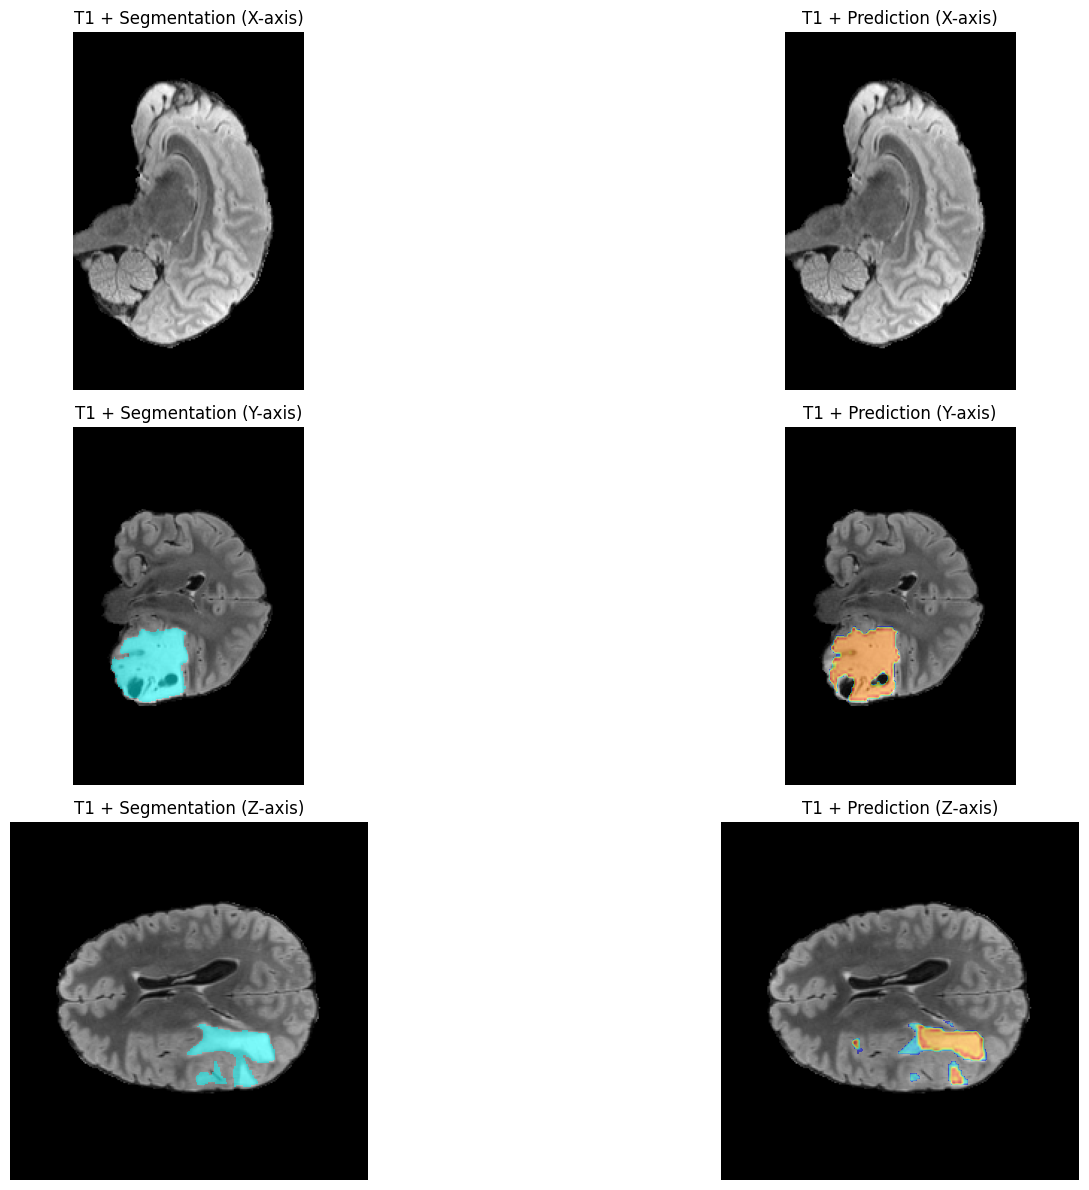

In [7]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# 파일 경로
t1_path = '/home/alpaco/msk/BraTS2021_Data/BraTS2021_00033/BraTS2021_00033_flair.nii.gz'
seg_file_path = '/home/alpaco/msk/BraTS2021_Data/BraTS2021_00033/BraTS2021_00033_seg.nii.gz'
pred_file_path = '/home/alpaco/msk/Unet3D_2021_flair/tumor_prediction_flair_dice_control.nii'

# 데이터 로드
t1_img = nib.load(t1_path).get_fdata()
seg_img = nib.load(seg_file_path).get_fdata()
pred_img = nib.load(pred_file_path).get_fdata()

# 정규화
t1_normalized = (t1_img - t1_img.min()) / (t1_img.max() - t1_img.min())

# 중심 슬라이스 계산
x_slice = t1_normalized.shape[0] // 2
y_slice = t1_normalized.shape[1] // 2
z_slice = t1_normalized.shape[2] // 2

# 슬라이스 리스트
slices = [
    (t1_normalized[x_slice, :, :], seg_img[x_slice, :, :], pred_img[x_slice, :, :], "X-axis"),
    (t1_normalized[:, y_slice, :], seg_img[:, y_slice, :], pred_img[:, y_slice, :], "Y-axis"),
    (t1_normalized[:, :, z_slice], seg_img[:, :, z_slice], pred_img[:, :, z_slice], "Z-axis"),
]

# 시각화
plt.figure(figsize=(18, 12))
for idx, (t1_slice, seg_slice, pred_slice, axis) in enumerate(slices):
    # T1과 Segmentation Overlay
    plt.subplot(3, 2, idx * 2 + 1)
    plt.imshow(t1_slice, cmap='gray')
    masked_seg = np.ma.masked_where(seg_slice == 0, seg_slice)
    plt.imshow(masked_seg, cmap='cool', alpha=0.5)
    plt.title(f'T1 + Segmentation ({axis})')
    plt.axis('off')

    # T1과 Prediction Overlay
    plt.subplot(3, 2, idx * 2 + 2)
    plt.imshow(t1_slice, cmap='gray')
    masked_pred = np.ma.masked_where(pred_slice < 0.1, pred_slice)  # Threshold 적용
    plt.imshow(masked_pred, cmap='jet', alpha=0.5)
    plt.title(f'T1 + Prediction ({axis})')
    plt.axis('off')

plt.tight_layout()
plt.show()
